We will train classification models (Logistic Regression and Naive Bayes) on the preprocessed dataset and evaluate their performance on training, validation, and test sets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np
import warnings
import mlflow.sklearn
warnings.filterwarnings('ignore')

/Users/hayden/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Random State
RNG = 42

In [3]:
mlflow.end_run()
mlflow.set_experiment("classification_models")

<Experiment: artifact_location='file:///Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/src/mlruns/379033497988179480', creation_time=1761583449178, experiment_id='379033497988179480', last_update_time=1761583449178, lifecycle_stage='active', name='classification_models', tags={}>

In [4]:
# Step 1: Load the data
df = pd.read_csv("../data/train.csv")

In [5]:
from project.src.utils import classify_price

# Step 2: Process Data
df['PriceCategory'] = df['SalePrice'].apply(classify_price)

print("PriceCategory distribution:")
print(df['PriceCategory'].value_counts())

# Idea from lecture: Combine features to create new ones
# Total square footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Total bathrooms
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

# House age and remodel age
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']

# Total porch area
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

# Drop columns that are just combined above
df = df.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
                'YearBuilt', 'YearRemodAdd',
                'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

# Remove Id and SalePrice columns
df = df.drop(['Id', 'SalePrice'], axis=1)

# Separate features and target
X = df.drop('PriceCategory', axis=1)
y = df['PriceCategory']

PriceCategory distribution:
PriceCategory
1    509
2    479
0    472
Name: count, dtype: int64


In [6]:
# Handle numeric and categorical features differently
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [7]:
# Pre-processing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
# Step 3: Split Data into Train (80%), Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG, stratify=y
)

Cross-validation scores: [0.75684932 0.72260274 0.7739726  0.77054795]
Mean CV accuracy: 0.7560

Training accuracy: 0.7637
Training F1 (weighted): 0.7532
Test accuracy: 0.7637
Test F1 (weighted): 0.7560

Confusion Matrix (Test Set):
[[84 10  0]
 [22 57 23]
 [ 2 12 82]]

Classes: 0 - Low, 1 - Medium, 2 - High


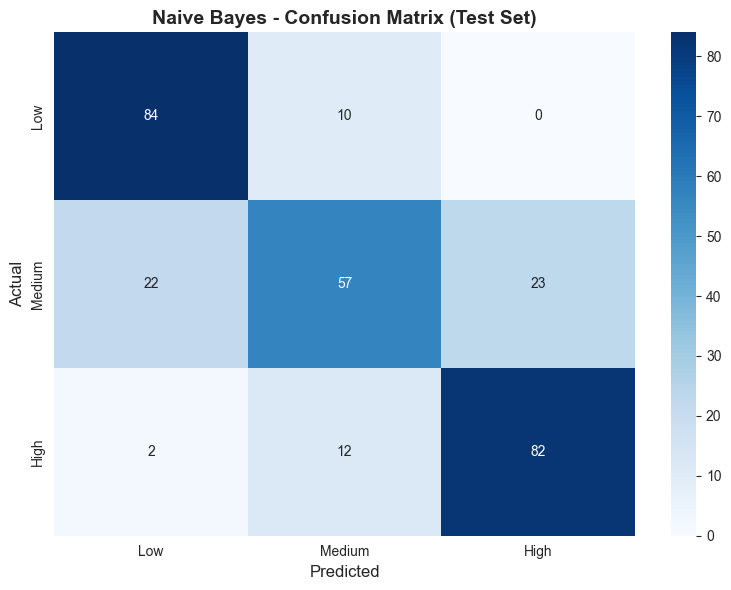

Naive Bayes model logged to MLflow


In [9]:
# Step 4: Train Naive Bayes Model and apply 4-fold cross-validation
with mlflow.start_run(run_name="Naive_Bayes"):
    mlflow.log_param("model_type", "GaussianNB")
    mlflow.log_param("cv_folds", 4)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", RNG)

    nb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
    nb_pipeline.fit(X_train, y_train)
    cv_scores_nb = cross_val_score(nb_pipeline, X_train, y_train, cv=4, scoring='accuracy')

    mlflow.log_metric("cv_mean_accuracy", cv_scores_nb.mean())
    mlflow.log_metric("cv_std_accuracy", cv_scores_nb.std())

    print(f"Cross-validation scores: {cv_scores_nb}")
    print(f"Mean CV accuracy: {cv_scores_nb.mean():.4f}")

    # Step 5: Evaluate Model Accuracy
    y_train_pred_nb = nb_pipeline.predict(X_train)
    train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
    train_f1_nb = f1_score(y_train, y_train_pred_nb, average='weighted')

    mlflow.log_metric("train_accuracy", train_accuracy_nb)
    mlflow.log_metric("train_f1", train_f1_nb)

    print(f"\nTraining accuracy: {train_accuracy_nb:.4f}")
    print(f"Training F1 (weighted): {train_f1_nb:.4f}")

    y_test_pred_nb = nb_pipeline.predict(X_test)
    test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
    test_f1_nb = f1_score(y_test, y_test_pred_nb, average='weighted')

    mlflow.log_metric("test_accuracy", test_accuracy_nb)
    mlflow.log_metric("test_f1", test_f1_nb)

    print(f"Test accuracy: {test_accuracy_nb:.4f}")
    print(f"Test F1 (weighted): {test_f1_nb:.4f}")

    print("\nConfusion Matrix (Test Set):")
    cm_nb = confusion_matrix(y_test, y_test_pred_nb)
    print(cm_nb)
    print("\nClasses: 0 - Low, 1 - Medium, 2 - High")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title('Naive Bayes - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'nb_confusion_matrix.png')
    plt.show()

    print("Naive Bayes model logged to MLflow")

Fitting 4 folds for each of 40 candidates, totalling 160 fits


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2


Best parameters: {'classifier__C': 0.1, 'classifier__max_iter': 2000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best CV score from GridSearch: 0.8245

Training accuracy: 0.8998
Training F1 (weighted): 0.8993
Test accuracy: 0.8390
Test F1 (weighted): 0.8390

Confusion Matrix (Test Set):
[[81 12  1]
 [13 79 10]
 [ 0 11 85]]

Classes: 0 - Low, 1 - Medium, 2 - High


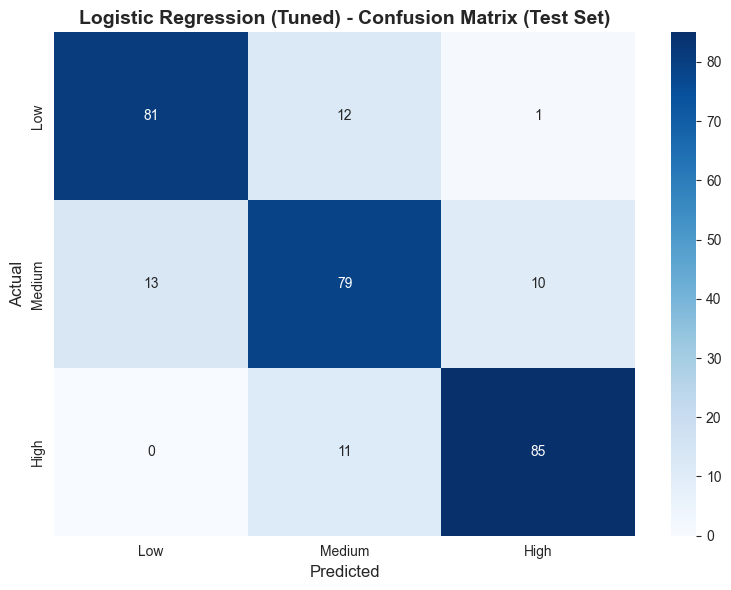

Logistic Regression model logged to MLflow


In [10]:
# Step 6: Train Logistic Regression Model with Hyperparameter Tuning
with mlflow.start_run(run_name="Logistic_Regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("cv_folds", 4)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", RNG)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("hyperparameter_tuning", "GridSearchCV")

    # Create pipeline
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=RNG))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.005, 0.01, 0.05, 0.1],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000]
    }

    grid_search = GridSearchCV(
        lr_pipeline,
        param_grid,
        cv=4,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    lr_pipeline = grid_search.best_estimator_

    print(f"\nBest parameters: {best_params}")
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # Step 7: Evaluate Model Accuracy
    mlflow.log_metric("best_cv_score", grid_search.best_score_)
    cv_scores_lr = grid_search.best_score_

    print(f"Best CV score from GridSearch: {grid_search.best_score_:.4f}")

    y_train_pred_lr = lr_pipeline.predict(X_train)
    train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
    train_f1_lr = f1_score(y_train, y_train_pred_lr, average='weighted')

    mlflow.log_metric("train_accuracy", train_accuracy_lr)
    mlflow.log_metric("train_f1", train_f1_lr)

    print(f"\nTraining accuracy: {train_accuracy_lr:.4f}")
    print(f"Training F1 (weighted): {train_f1_lr:.4f}")

    y_test_pred_lr = lr_pipeline.predict(X_test)
    test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
    test_f1_lr = f1_score(y_test, y_test_pred_lr, average='weighted')

    mlflow.log_metric("test_accuracy", test_accuracy_lr)
    mlflow.log_metric("test_f1", test_f1_lr)

    print(f"Test accuracy: {test_accuracy_lr:.4f}")
    print(f"Test F1 (weighted): {test_f1_lr:.4f}")

    print("\nConfusion Matrix (Test Set):")
    cm_lr = confusion_matrix(y_test, y_test_pred_lr)
    print(cm_lr)
    print("\nClasses: 0 - Low, 1 - Medium, 2 - High")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title('Logistic Regression (Tuned) - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'lr_confusion_matrix.png')
    plt.show()

    print("Logistic Regression model logged to MLflow")

In [11]:
# Summary
print(f"\nNaive Bayes:")
print(f"  - Mean CV Accuracy: {cv_scores_nb.mean():.4f} (+/- {cv_scores_nb.std():.4f})")
print(f"  - Training Accuracy: {train_accuracy_nb:.4f}")
print(f"  - Test Accuracy: {test_accuracy_nb:.4f}")

print(f"\nLogistic Regression:")
print(f"  - Mean CV Accuracy: {grid_search.best_score_:.4f}")
print(f"  - Training Accuracy: {train_accuracy_lr:.4f}")
print(f"  - Test Accuracy: {test_accuracy_lr:.4f}")


Naive Bayes:
  - Mean CV Accuracy: 0.7560 (+/- 0.0203)
  - Training Accuracy: 0.7637
  - Test Accuracy: 0.7637

Logistic Regression:
  - Mean CV Accuracy: 0.8245
  - Training Accuracy: 0.8998
  - Test Accuracy: 0.8390


In [12]:
# Which features are most important in determining the house price?
preprocessor_fitted = lr_pipeline.named_steps['preprocessor']
num_feature_names = numeric_features
cat_feature_names = preprocessor_fitted.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
all_feature_names = num_feature_names + cat_feature_names

# Get coefficients from Logistic Regression
lr_classifier = lr_pipeline.named_steps['classifier']
coefficients = lr_classifier.coef_

# Calculate the average absolute coefficient across all classes
avg_abs_coef = np.mean(np.abs(coefficients), axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': avg_abs_coef
})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print("TOP 10 MOST IMPORTANT FEATURES (Logistic Regression)")
print("-"*40)
print(feature_importance_df.head(10).to_string(index=False))

TOP 10 MOST IMPORTANT FEATURES (Logistic Regression)
----------------------------------------
             Feature  Importance
             TotalSF    0.563030
           GrLivArea    0.502179
         OverallQual    0.470625
    RoofMatl_ClyTile    0.236756
          GarageArea    0.233959
           TotalBath    0.188805
      KitchenQual_TA    0.173126
          Fireplaces    0.164970
Neighborhood_Crawfor    0.140521
           YearBuilt    0.135845


In [13]:
# Train and Test Metrics and F1 Table
metrics_data = {
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'CV Accuracy': [
        f"{cv_scores_nb.mean():.4f}",
        f"{cv_scores_lr.mean():.4f}"
    ],
    'Train Accuracy': [train_accuracy_nb, train_accuracy_lr],
    'Train F1': [train_f1_nb, train_f1_lr],
    'Test Accuracy': [test_accuracy_nb, test_accuracy_lr],
    'Test F1': [test_f1_nb, test_f1_lr],
}

metrics_df = pd.DataFrame(metrics_data)

for col in ['Train Accuracy', 'Train F1', 'Test Accuracy', 'Test F1']:
    metrics_df[col] = metrics_df[col].apply(lambda x: f"{x:.4f}")

print("\n" + "-"*80)
print("CLASSIFICATION METRICS FOR ALL MODELS: Accuracy, and F1 on Validation (CV) and Test")
print("-"*80)
print(metrics_df.to_string(index=False))
print("-"*80)


--------------------------------------------------------------------------------
CLASSIFICATION METRICS FOR ALL MODELS: Accuracy, and F1 on Validation (CV) and Test
--------------------------------------------------------------------------------
              Model CV Accuracy Train Accuracy Train F1 Test Accuracy Test F1
        Naive Bayes      0.7560         0.7637   0.7532        0.7637  0.7560
Logistic Regression      0.8245         0.8998   0.8993        0.8390  0.8390
--------------------------------------------------------------------------------


In [15]:
mlflow.end_run()